In [26]:
import cv2 as cv
import albumentations as A
import os
import sys
import datetime
import io

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import (
    Conv2D,
    MaxPool2D,
    Dense,
    Flatten,
    Input,
    BatchNormalization,
    Layer,
    InputLayer,
    Dropout,
    Resizing,
    Rescaling,
    RandomFlip,
    RandomRotation,
    GlobalAveragePooling2D,
    Add,
    MultiHeadAttention,
    Embedding,
    LayerNormalization,
)
from tensorflow.keras.losses import (
    BinaryCrossentropy,
    CategoricalCrossentropy,
    SparseCategoricalCrossentropy,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import (
    CategoricalAccuracy,
    TopKCategoricalAccuracy,
)
from tensorflow.keras.callbacks import (
    Callback,
    CSVLogger,
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.regularizers import L2, L1
import tensorflow_probability as tfp
from tensorboard.plugins.hparams import api as hp

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve

# from google.colab import drive
# drive.mount('/content/drive')
# TRAIN_DIR = "/content/drive/MyDrive/tfds_data/datasets/Emotions Dataset/Emotions Dataset/train"
# TEST_DIR = "/content/drive/MyDrive/tfds_data/datasets/Emotions Dataset/Emotions Dataset/test"

TRAIN_DIR = "./datasets/Emotions Dataset/Emotions Dataset/train"
TEST_DIR = "./datasets/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry", "happy", "sad"]  # This needs to be in accord with dir names.

CONFIG = {
    "batch_size": 32,
    "im_shape": (256, 256),
    "im_size": 256,
    "input_shape": (None, None, 3),
    "filters_1": 6,
    "filters_2": 16,
    "kernel_size": 3,
    "activation_1": "relu",
    "activation_2": "softmax",
    "dropout": 0.01,
    # "dropout": 0.00,
    "regularization_l2": 0.1,
    # "regularization_l2": 0.0,
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "pool_size": 2,
    "strides_1": 1,
    "strides_2": 2,
    "dense_1": 32,
    "dense_2": 32,
    "dense_3": 32,
    "dense_out": 3,
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 25,
    "patch_size":16,
}

In [27]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    # NOTE: int -> [0,1,2]; categorical -> (1,0,0) | (0,1,0) | (0,0,1)
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIG["batch_size"],
    # batch_size=None,
    image_size=CONFIG["im_shape"],
    shuffle=True,
    seed=10,
).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    # NOTE: int -> 0 | 1 | 2; categorical -> (1,0,0) | (0,1,0) | (0,0,1)
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIG["batch_size"],
    # batch_size=None,
    image_size=CONFIG["im_shape"],
    shuffle=True,
    seed=10,
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


# Testing image patch

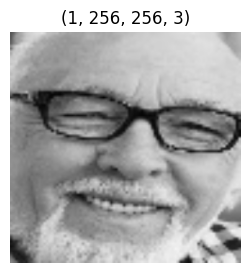

In [4]:
img = cv.imread("./datasets/Emotions Dataset/Emotions Dataset/test/happy/43189.jpg")[:,:,::-1]
img = cv.resize(img, (256, 256))
img = tf.constant(img, dtype=tf.float32)
img = tf.expand_dims(img, axis=0)

plt.figure(figsize=[3,3])
plt.imshow(img[0]/255.0)
plt.title(img.shape)
plt.axis("off")
plt.show()

In [19]:
# rates -> it's like a dilation for the kernel.
# padding="VALID" -> applies padding automatically if necessary.
# [1, 16, 16, 1] -> [batch, rows, cols, depth]
patches = tf.image.extract_patches(img, sizes=[1, 16, 16, 1], strides=[1,16,16,1], rates=[1,1,1,1], padding="VALID")
# The last layer is 768 because the embedding image patch is 16x16 (which is 256), but it's a RGB image, so 16x16x3 == 768.
print(patches.shape)

# Flattening the embedding image patches
# patches = tf.reshape(patches, (patches.shape[0], 256, 768))
patches = tf.reshape(patches, (patches.shape[0], -1, patches.shape[-1]))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


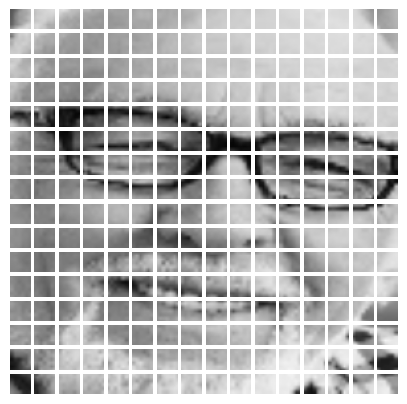

In [22]:
plt.figure(figsize=[5,5])

_patches = patches/255.0
for i in range(patches.shape[1]):
    # 16x16 because we know the image original shape is 256x256. NOTE: (16*16==256)
    plt.subplot(16, 16, i+1)
    # [0, i, :]:
    # - 0 >> There's only one image in the batch.
    # - i >> the current embedding image patch.
    # - : >> This says "take all values from the depth dimensions for the image patch `i`". In this case, the patches depth is 768, which is 16x16x3.
    plt.imshow(tf.reshape(_patches[0, i, :], (16, 16, 3)))
    plt.axis("off")
    
plt.show()

# Visual Transformer (ViT) 

In [7]:
# Could also be called LinearProjector or similar.
class PatchEncoder(Layer):
    # hidden_size == size of the embbeding patches vector.
    # n_pathes == number of groups of pixes to which the image will be divided.
    def __init__(self, n_patches, hidden_size):
        super(PatchEncoder, self).__init__(name = "patch_encoder")

        self.n_patches = n_patches
        self.hidden_size = hidden_size
        self.linear_projection = Dense(hidden_size, activation=tf.nn.gelu)
        # Dense performs a weighted sum, but Embedding simply performs a matrix multiplication.
        self.positional_embedding = Embedding(n_patches, hidden_size)

    def call(self, x):
        patches = tf.image.extract_patches(
            x,
            sizes=[1, CONFIG["patch_size"], CONFIG["patch_size"], 1],
            strides=[1, CONFIG["patch_size"], CONFIG["patch_size"], 1],
            rates=[1,1,1,1],
            padding="VALID",
        )
        # patches = tf.reshape(patches, (pacthes.shape[0], -1, patches.shape[-1]))
        # NOTE: throws an error if the last batch doesn't have exactly CONFIG["batch_size"]||32 elements (which is often true).
        # patches = tf.reshape(patches, (CONFIG["batch_size"], -1, patches.shape[-1]))
        patches = tf.reshape(patches, (tf.shape(patches)[0], -1, patches.shape[-1]))    

        embedding_input = tf.range(start=0, limit=self.n_patches, delta=1)
        output = self.linear_projection(patches) + self.positional_embedding(embedding_input)

        return output

In [11]:
# p = PatchEncoder(256, 768)
p = PatchEncoder(256, 900) # Yes, 900 is valid.
p(tf.zeros((1, 256, 256, 3)))

<tf.Tensor: shape=(1, 256, 900), dtype=float32, numpy=
array([[[ 0.01976234, -0.00200902, -0.00054082, ..., -0.0242416 ,
          0.02531887,  0.04275149],
        [ 0.01709855, -0.00064428,  0.04570227, ..., -0.02644622,
         -0.04518235, -0.0240725 ],
        [-0.02455486, -0.00921506, -0.03475698, ...,  0.0434748 ,
          0.01099045, -0.02279288],
        ...,
        [ 0.03484248, -0.01289114,  0.01908865, ..., -0.02825153,
         -0.04527506,  0.0269124 ],
        [ 0.02558824, -0.02412229,  0.008494  , ...,  0.00314789,
          0.0491321 , -0.03822938],
        [ 0.02673275, -0.04711865, -0.03044673, ...,  0.00386335,
          0.02012051,  0.00162305]]], dtype=float32)>

In [24]:
class TransformerEncoder(Layer):
    def __init__(self, n_heads, n_hidden):
        super(TransformerEncoder, self).__init__(name="transformer_encoder")
        self.n_heads = n_heads
        self.n_hidden = n_hidden

        self.norm_1 = LayerNormalization()
        self.norm_2 = LayerNormalization()
        self.multi_head_attention = MultiHeadAttention(num_heads=n_heads, key_dim=n_hidden, value_dim=None)

        # NOTE: These two make the MLP (Multilayer Perceptron)
        self.mlp_dense_1 = Dense(n_hidden, activation=tf.nn.gelu)
        self.mlp_dense_2 = Dense(n_hidden, activation=tf.nn.gelu)

    def call(self, x_input):
        x_1 = self.norm_1(x_input)
        """
        The multi_head_attention layer receives x_1 as both the query and value. 
        This is because the self-attention mechanism in the Transformer is 
        designed to allow each position (or token) in the input to attend to all
        other positions in that same input sequence.
        """
        # NOTE: Anything familiar here? Hint: Scaled Dot Product Attention 
        x_1 = self.multi_head_attention(query=x_1, value=x_1, key=None)
        x_1 = Add()([x_input, x_1])
        
        x_2 = self.norm_2(x_1)
        x_2 = self.mlp_dense_1(x_2)
        x_2 = self.mlp_dense_2(x_2)
        x_2 = Add()([x_1, x_2])

        return x_2

In [25]:
t = TransformerEncoder(8, 768)
# t = TransformerEncoder(8, 900) # Now 900 it doesn't work if we try to call the next line as it is.
t(tf.zeros((1, 256, 768)))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [39]:
class VisionTransformer(Model):
    def __init__(self, n_heads, n_patches, n_hidden, n_transformers, mlp_dense_size, dense_out_size=len(CLASS_NAMES)):
        super(VisionTransformer, self).__init__(name="vision_transformer")

        self.patch_encoder = PatchEncoder(n_patches, n_hidden)
        self.transformers = [TransformerEncoder(n_heads, n_hidden) for _ in range(n_transformers)]
        self.mlp_dense_1 = Dense(mlp_dense_size, activation=tf.nn.gelu)
        self.mlp_dense_2 = Dense(mlp_dense_size, activation=tf.nn.gelu)
        self.dense_out = Dense(dense_out_size, activation="softmax")

    def call(self, x_in):
        x = self.patch_encoder(x_in)
        for transformer in self.transformers:
            x = transformer(x)

        """
        In the original implementation of the ViT, we would actually
        have a special embedding patch called "learnable embedding patch"
        which acts as a summary containing important imformations about
        all other elements in the sequence vector (the embedding image 
        patch vector). But the learnable embedding patch is not extrictly 
        necessary in the ViT (contrary from the NLP implementation of a
        Transformer), so we just Flatten out every patch from the sequence. 
        Search it out.
        """
        x = Flatten()(x)
        x = self.mlp_dense_1(x)
        x = self.mlp_dense_2(x)
        x_out = self.dense_out(x)
        
        return x_out
        

In [43]:
vit = VisionTransformer(n_heads=4, n_patches=256, n_hidden=768, n_transformers=2, mlp_dense_size=128, dense_out_size=len(CLASS_NAMES))
vit(tf.zeros([1, 256, 256, 3])) # Building the model, as always.

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.42662215, 0.13212751, 0.44125035]], dtype=float32)>

In [44]:
vit.summary()

Model: "vision_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patch_encoder (PatchEncoder)    │ ?                      │       787,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ ?                      │    10,631,424 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ ?                      │    10,631,424 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (1, 128)               │    25,165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (1, 128)               │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (1, 3)                 │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,232,899 (180.18 MB)

 Trainable params: 47,232,899 (180.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vit.compile(
    optimizer=Adam(learning_rate=CONFIG["learning_rate"]),
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=2)]
)
# NOTE: Te ViT must train on LARGE, I mean VERY LARGE datasets, so for this dataset we'll get poor training results.
# NOTE 2: After the training, we perform fine-tuning in a smaller dataset for the ViT.
history = vit.fit(train_dataset, validation_data=test_dataset, epochs=1, verbose=1, callbacks=None)